In [1]:
# import numpy, astropy and matplotlib for basic functionalities
import pkg_resources
from pathlib import Path
import numpy as np
import astropy.units as u
from astropy.constants import c
from astropy.table import Table
from astropy.coordinates import Distance
import matplotlib.pyplot as plt

# import agnpy classes
from agnpy.spectra import BrokenPowerLaw
from agnpy.synchrotron import Synchrotron
from agnpy.compton import SynchrotronSelfCompton
from agnpy.wrappers import SynchrotronSelfComptonSpectralModel
from agnpy.wrappers import add_systematic_errors_flux_points
from agnpy.utils.plot import load_mpl_rc, sed_x_label, sed_y_label

# import gammapy classes
from gammapy.modeling.models import SPECTRAL_MODEL_REGISTRY, SkyModel
from gammapy.estimators import FluxPoints
from gammapy.datasets import Datasets, FluxPointsDataset
from gammapy.modeling import Fit

# IMPORTANT: add the new custom model to the registry of spectral models recognised by gammapy
SPECTRAL_MODEL_REGISTRY.append(SynchrotronSelfComptonSpectralModel)

In [2]:
# the run_mcmc method has been moved from gammapy/gammapy to gammapy/recipes
# please download the gammapy-recipes
# https://github.com/gammapy/gammapy-recipes
# and change the following path accordingly
import sys

sys.path.append("/Users/cosimo/work/gammapy-recipes/recipes/mcmc-sampling-emcee")
from sampling import (
    run_mcmc,
    par_to_model,
    plot_corner,
    plot_trace,
)

In [3]:
# electron energy distribution
n_e = BrokenPowerLaw(
    k_e=1.3e-8 * u.Unit("cm-3"),
    p1=2.02,
    p2=3.43,
    gamma_b=1e5,
    gamma_min=500,
    gamma_max=1e6,
)

# initialise the Gammapy SpectralModel
ssc_model = SynchrotronSelfComptonSpectralModel(n_e)

In [4]:
ssc_model.parameters["z"].value = 0.0308
ssc_model.parameters["delta_D"].value = 18
ssc_model.parameters["B"].value = 0.05

In [5]:
ssc_model.parameters.to_table()

type,name,value,unit,error,min,max,frozen,is_norm,link
str8,str9,float64,str4,int64,float64,float64,bool,bool,str1
spectral,k_e,1.3000e-08,cm-3,0.000e+00,1.000e-10,1.000e+02,False,False,
spectral,p1,2.0200e+00,,0.000e+00,1.000e+00,5.000e+00,False,False,
spectral,p2,3.4300e+00,,0.000e+00,1.000e+00,5.000e+00,False,False,
spectral,gamma_b,1.0000e+05,,0.000e+00,1.000e+02,1.000e+06,False,False,
spectral,gamma_min,5.0000e+02,,0.000e+00,1.000e+00,1.000e+03,True,False,
spectral,gamma_max,1.0000e+06,,0.000e+00,1.000e+05,1.000e+08,True,False,
spectral,z,3.0800e-02,,0.000e+00,1.000e-03,1.000e+01,True,False,
spectral,delta_D,1.8000e+01,,0.000e+00,1.000e+00,1.000e+02,False,False,
spectral,B,5.0000e-02,G,0.000e+00,1.000e-04,1.000e+02,False,False,


In [6]:
datasets = Datasets()
flux_points = {}

sed_path = pkg_resources.resource_filename("agnpy", "data/mwl_seds/Mrk421_2011.ecsv")
table = Table.read(sed_path)
table = table.group_by("instrument")

# do not use frequency point below 1e11 Hz, affected by non-blazar emission
E_min_fit = (1e11 * u.Hz).to("eV", equivalencies=u.spectral())

for group in table.groups:
    name = group["instrument"][0]

    data = FluxPoints.from_table(group, sed_type="e2dnde", format="gadf-sed")
    dataset = FluxPointsDataset(data=data, name=name)

    flux_points.update({name: data})
    dataset.mask_fit = dataset.data.energy_ref > E_min_fit
    datasets.append(dataset)

# load the SSC model in the datasets
model = SkyModel(spectral_model=ssc_model, name="Mrk421")
datasets.models = [model]

No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.
No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.
No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.
No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.
No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.
No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.
No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.
No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.
No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.
No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.
No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.
No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.
No reference model set for FluxMaps. Assuming point 

In [7]:
%%time
sampler = run_mcmc(datasets, nwalkers=18, nrun=400)

CPU times: user 1h 25min 21s, sys: 10min 4s, total: 1h 35min 26s
Wall time: 1h 37min 32s


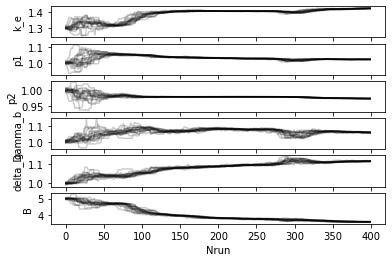

In [8]:
plot_trace(sampler, datasets)

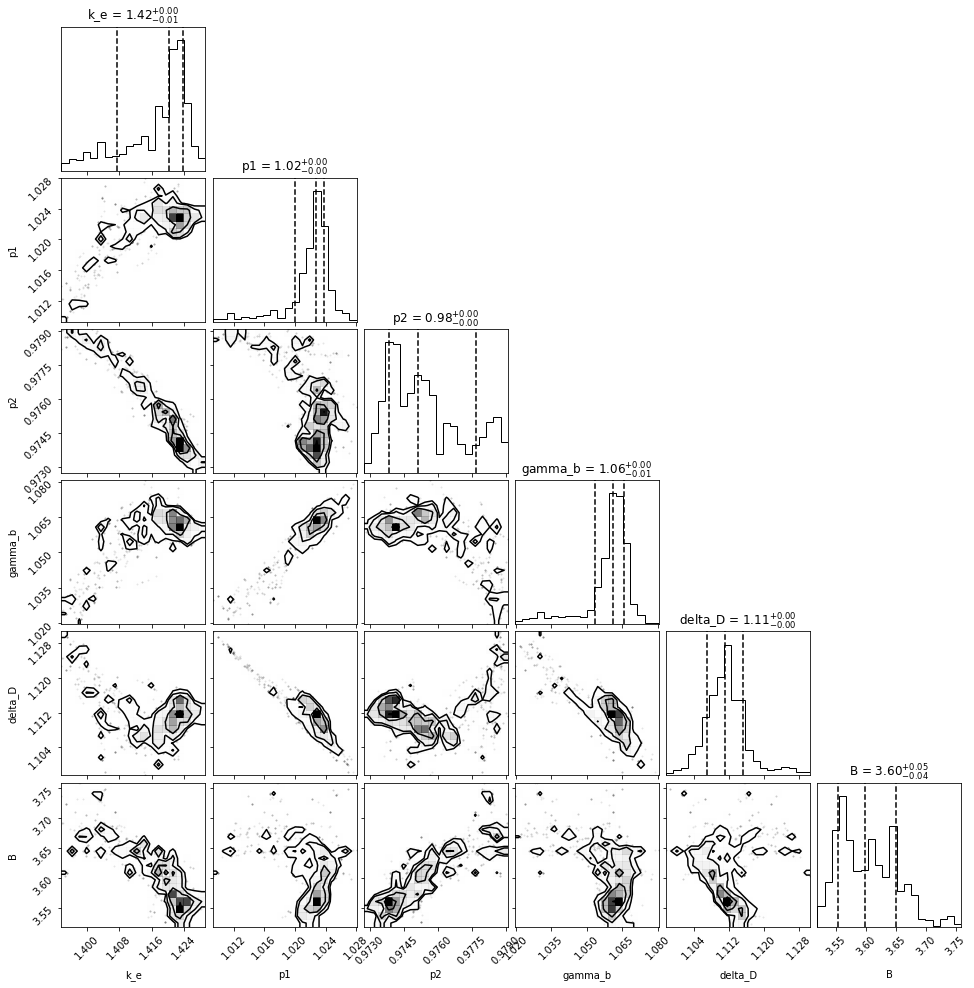

In [9]:
plot_corner(sampler, datasets, nburn=300)

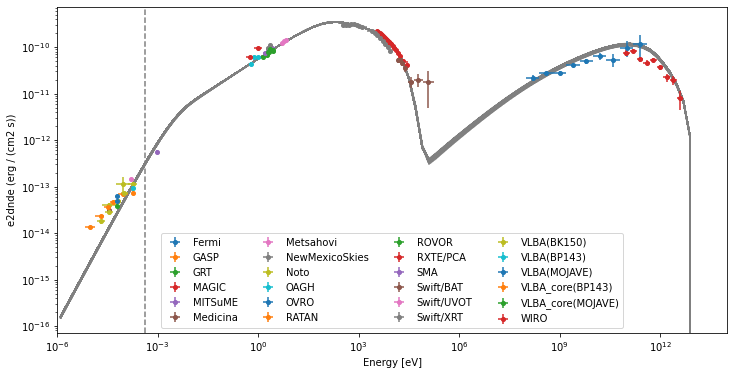

In [11]:
emin, emax = [1e-6, 1e14] * u.eV

fig, ax = plt.subplots(figsize=(12, 6))
    
for nwalk in range(0, 18):
    for n in range(300, 400):
        pars = sampler.chain[nwalk, n, :]

        # set model parameters
        par_to_model(datasets, pars)
        ssc_model = datasets.models["Mrk421"].spectral_model
        
        ssc_model.plot(
            energy_bounds=(emin, emax),
            ax=ax,
            energy_power=2,
            alpha=0.02,
            color="grey",
            yunits=u.Unit("erg cm-2 s-1")
        )

# plot a line marking the minimum energy considered in the fit
ax.axvline(E_min_fit, ls="--", color="gray")

for key in flux_points.keys():
    flux_points[key].plot(ax=ax, label=key)

plt.legend(ncol=4)
plt.xlim([1e-6, 1e14])
plt.show()